For our models we see Qg_l, the gravitational energy associated with remixing the molten snow across the liquid region below, decreasing with higher Sulphur contents. Our expectation was that more Sulphur in the core leads to more snow and larger amounts of gravitational energy.

Below I calculate 2 models, the same except one has 5 wt% and one has 10 wt% Sulphur. The key information is the print out of the integral terms below. The reason we see smaller gravitational energies is due to S impacting the material properties, namely density and chemical expansivity, reducing Qg_l.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import trapezoid
import sys

sys.path.append('../useful_scripts')#Make useful scripts directory visible to import our custom setup_model
import eos_setup_model

import thermal_history as th
from thermal_history.core_models.leeds.routines import rivoldini_eos as eos

#Load parameters
prm = th.model.Parameters(('../300km/300_params.py',))
prm.stable_layer = False

#Loop over different compositions
S_array = [0.05, 0.15]

q_cmb   = 10       #mW/m^2 Constant CMB heat flux.

models = [] #Save models into list

#Begin loops
for S in S_array:
   prm.conc_l[0] = S  #Set composition

   #Setup model
   model = eos_setup_model.setup_model(prm, core_method='leeds', verbose=False)
   print(f'S = {S}')

   model.mantle.Q_cmb = q_cmb*1e-3 * 4*np.pi*prm.r_cmb**2 #Set constant CMB heat flow

   #Run model, breaking when snow zone covers whole core or non top-down freezing occurs
   #either will cause model.critical_failure = True as it is not defined in the model
   #how proceed in these scenarios

   dt = 1e4*prm.ys
   while not model.critical_failure and model.it < (4.5e9*prm.ys/dt):

      model.evolve(dt, print_freq=100, verbose=True) #Evolve model

      #Break just as the snow zone covers the whole core and append to our list.
      if model.core.r_snow == 0:
         models.append(model)
         break

S = 0.05
iteration: 100    Tcen: 1856.77 ˚K    Q(rs): 0.01 TW    ADR(rs): 3.61    snow depth: 144.83 km
S = 0.15
iteration: 100    Tcen: 1623.43 ˚K    Q(rs): 0.01 TW    ADR(rs): 10.15    snow depth: 8.85 km
iteration: 200    Tcen: 1622.62 ˚K    Q(rs): 0.01 TW    ADR(rs): 10.16    snow depth: 19.06 km
iteration: 300    Tcen: 1621.81 ˚K    Q(rs): 0.01 TW    ADR(rs): 10.16    snow depth: 31.04 km
iteration: 400    Tcen: 1621.00 ˚K    Q(rs): 0.01 TW    ADR(rs): 10.17    snow depth: 45.71 km
iteration: 500    Tcen: 1620.19 ˚K    Q(rs): 0.01 TW    ADR(rs): 10.17    snow depth: 64.99 km
iteration: 600    Tcen: 1619.39 ˚K    Q(rs): 0.01 TW    ADR(rs): 10.18    snow depth: 94.36 km
iteration: 700    Tcen: 1618.59 ˚K    Q(rs): 0.01 TW    ADR(rs): 10.18    snow depth: 191.12 km


In [32]:
from scipy.integrate import trapezoid

for m in models:
    print('----------------------')
    print(f'S={m.core.initial_conc_l*100}')
    print(f'density = {m.parameters.core_liquid_density_params}')
    print(f'alpha_c = {m.parameters.alpha_c}')
    prof = m.core.profiles

    #Index for arrays of snow zone radius
    idx = np.where(prof['Cl']==0)[0][-1]
    r, rho, psi = prof['r'][:idx], prof['rho'][:idx], prof['psi'][:idx]

    print(f'r_snow = {r[-1]/1000:.1f}km')
    vol = trapezoid(r**2, x=r)
    #Normalise to the liquid region volume as r_snow is not quite at the same radius in both models.

    print('')
    integral = trapezoid(rho*r**2, x=r)/vol
    print(f'Integral of rho: {integral:.1e}')

    integral = trapezoid(psi*rho*r**2, x=r)/vol
    print(f'Integral of rho*psi: {integral:.1e}')

    integral = trapezoid(psi*rho*r**2 * m.parameters.alpha_c, x=r)/vol
    print(f'Integral of rho*psi*alpha: {integral:.1e}')

    integral = trapezoid(psi*rho*r**2 * m.parameters.alpha_c*m.core.Cp, x=r)/vol
    print(f'Integral of rho*psi*alpha*Cp: {integral:.1e}')

    integral = trapezoid(psi*rho*r**2 * m.parameters.alpha_c*(m.core.Cp+m.core.Cc*m.core.Cr), x=r)/vol
    print(f'Integral of rho*psi*alpha*(Cp+Cc*Cr): {integral:.1e}')

    print(f'Qg_l = {m.core.Qg_l[0]/vol:.1e}')


----------------------
S=5.0
density = [6781.82827656]
alpha_c = [1.56722776]
r_snow = 41.5km

Integral of rho: 6.8e+03
Integral of rho*psi: -5.7e+08
Integral of rho*psi*alpha: -9.0e+08
Integral of rho*psi*alpha*Cp: -1.0e+08
Integral of rho*psi*alpha*(Cp+Cc*Cr): -1.0e+08
Qg_l = 2.6e-05
----------------------
S=15.0
density = [6130.26571837]
alpha_c = [0.85752587]
r_snow = 48.1km

Integral of rho: 6.1e+03
Integral of rho*psi: -4.7e+08
Integral of rho*psi*alpha: -4.0e+08
Integral of rho*psi*alpha*Cp: -3.0e+07
Integral of rho*psi*alpha*(Cp+Cc*Cr): -3.0e+07
Qg_l = 9.8e-06


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


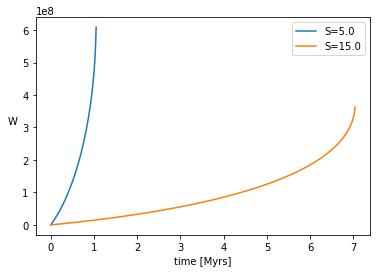

dict_keys(['r', 'rho', 'g', 'P', 'cp', 'alpha', 'psi', 'Ta', 'dTa_dr', 'T', 'conc_l', 'dS', 'Tm_fe', 'Tm', 'dTm_dP', 'k', 'Qa', 'L', 'Cl', 'phi_snow'])


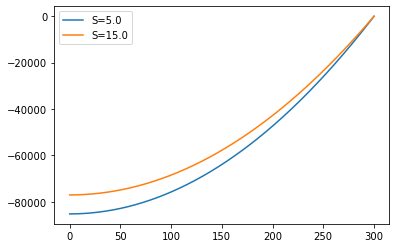

In [30]:
m1 = models[0]
m1_data = m1.save_dict_to_numpy_array()
prof1   = m1.core.profiles

m2 = models[1]
m2_data = m2.save_dict_to_numpy_array()
prof2   = m2.core.profiles

ys = m1.parameters.ys

#Plot Qg_l time series
for data in [m1_data, m2_data]:
    S = float(data['core']['conc_l'][0])
    time = data['core']['time']/(ys*1e6)
    Qg_l = data['core']['Qg_l']
    plt.plot(time, Qg_l, label=f'S={S*100}')

plt.xlabel('time [Myrs]')
plt.ylabel('W', rotation=0, labelpad=10)
plt.legend(loc=0)
plt.show()

#Plot radial profiles at last time step
print(prof1.keys()) #Available profiles

for m in models:
    prof = m.core.profiles

    plt.plot(prof['r']/1000, prof['psi'], label=f'S={m.core.initial_conc_l*100}')

plt.legend(loc=0)
plt.show()